# Implementación del algoritmo K-means++ con cálculo del número de clústeres relativamente oṕtimo de manera concurrente.

El objetivo de este notebook es implementar mi propia versión del algoritmo k-means expresado en el libro Liu, B., & Mining, W. D. (2011). Web Data Mining. Exploring Hyperlinks, Contents, and Usage Data. Ser. Data-Centric Systems and Applications. Springer Berlin Heidelberg. Capítulo 4 - Unsupervised Learning.

La implementación se realizará usando el lenguaje de programación Python.

A su vez, como datos de entrada se usarán los pertencientes al archivo dataset1.csv en la carpeta Datasets.

Primero importamos la librería matplotlib para la representación de valores en una gráfica de 2 dimensiones.
También importamos la librería random para generar números aleatorios. También importamos la librería metrics de sklearn para calcular el índice Calinski-Harabasz con el que calcularemos la cohesión de cada agrupación de clústeres.

In [2]:
import matplotlib.pyplot as plt
import random
import math
from sklearn import metrics

Acto seguido cogemos los valores del fichero de entrada y los guardamos en un string:

In [3]:
with open("Datasets/dataset1.csv") as input_file:
    input_values = input_file.read()

Ahora dividimos los datos en puntos independientes y los añadimos a una lista aparte. En esta lista hemos eliminado el primer elemento ya que actuaba de patrón indicando como se representan los valores de cada punto:

In [4]:
x = [] # List of x values
y = [] # List of y values
point_class = []
for point in input_values.splitlines()[1 :: ]:
    splitted_point = point.split(",")
    x.append(float(splitted_point[0]))
    y.append(float(splitted_point[1]))
    point_class.append(float(splitted_point[2]))

Una vez conseguidos los puntos, procedemos a representarlos en la gráfica:

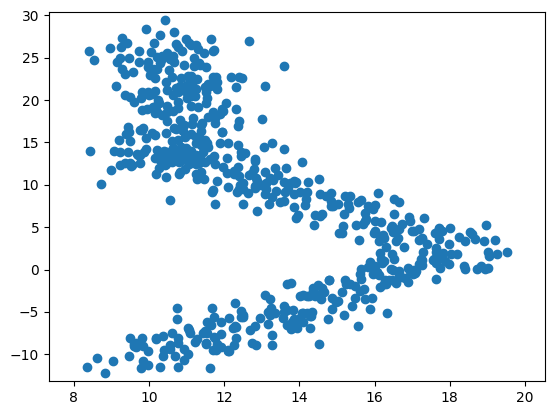

In [5]:
plt.ylim(min(y) - 1, max(y) + 1)
plt.xlim(min(x) - 1, max(x) + 1)
plt.scatter(x, y)
plt.show()

Como se puede apreciar, a la hora de representar los puntos no se tiene encuenta su clase ya que todos ellos estan superpuestos en el mismo mapa.

### Implementación de la mejora propuesta por KMeans++

Basándonos en el algoritmo K-Means creado anteriormente, procedemos a "mejorarlo" a su versión K-Means++ con el fin de dividir el conjunto de todos los datos en clústeres de una forma más consistente. La modificación que introduce esta "mejora" es la forma de seleccionar los centroides iniciales, que, al igual que en su versión no mejorada, no se podrán repetir. Estos centroides iniciales se seleccionaran de la siguiente forma:
    
1. Se selecciona el primer centro de forma aleatoria entre todos los puntos del dataset.
2. Una vez seleccionado el centroide, se calcula la distancia de todos los puntos del dataset y se asignan al centroide más cercano a cada uno de ellos.
3. Cuando todos los puntos se han asignado a un centroide, se procede a escoger como centroide para otro clúster el punto más lejano al centroide del clúster que acabamos de crear. (Si acabábamos de crear el centroide número K, entonces el algoritmo debería parar y no seguir calculando centros.)

Se ha extraido el fragmento de selección de centros iniciales con el fin de mostrar de forma más precisa los cambios realizados. Se puede apreciar que conviven la versión antigua y la nueva, pero el propósito de la coexistecia de ambas es símplemente para la comparación de resultados entre ambas versiones. 

La siguiente función calcula la media de todos los puntos de un clúster con el fin de hallar un nuevo centro para el clúster.

In [6]:
def mean(list): # Función que calcula la media de una lista
    acc = 0
    for i in list:
        acc = acc + i
    return acc/len(list)

El siguiente fragmento de código pertenece a la selección de centroides iniciales de forma aleatoria propuesta por el algoritmo KMeans original.

In [7]:
def initialize(k="Number of centroids", d="Data points"):
    centroids = []
    old_centroids = []
    clusters = [] # Creo K clusters con 3 listas, una para la x otra para la y y otra para la clase del punto respectivamente

    for i in range(k): # Calculo los centroides incialesNow
        point_position = -1 # posicion del centroide elegido
        while(point_position == -1): # Escogemos un numero aleatorio entre 0 y el número de puntos que tenemos, mientras los centroides estén repetidos, elijo un nuevo centroide
            point_position = random.randrange(0, len(x)-1)
            if((d[0][point_position], d[1][point_position], d[2][point_position]) in centroids): # si el centroide está repetido, escogemos uno nuevo
                point_position = -1    
        centroids.append((x[point_position], y[point_position], point_class[point_position])) # Elegimos k centroides al azar
        old_centroids.append([[], [], []])
        clusters.append([[], [], []])
    
    return centroids, old_centroids, clusters;    

Este otro fragmento es la selección de centros mediante KMeans++. (El primer centro se sigue escogiendo de forma aleatoria)

In [8]:
def initialize(k="Number of centroids", d="Data points"):
    centroids = []
    point_distance_to_centroids = [[]] # Guarda la distancia de cada punto a cada centroide

    point_position = random.randrange(0, len(d[0]) - 1) # Primero selecciono un centroide aleatorio inicial.
    centroids.append((d[0][point_position], d[1][point_position], point_class[point_position]))
    
    assigned_centroid = [[0] for i in range(len(d[0]))] # Captura el índice del centroide al que se asignará cada punto
    clusters = [] # Guarda los puntos que tiene asiǵnados cada clúster
    # Calculo la distancia de todos los puntos a este centroide
    for point_index in range(len(d[0])):
        point_distance_to_centroids[0].append(abs(math.sqrt(pow(centroids[0][0] - d[0][point_index], 2) + (pow(centroids[0][1] - d[1][point_index], 2)))))

    clusters = point_distance_to_centroids[0].copy()
    
    # Calculo el siguiente centroide, que va a ser el punto más lejano del centroide calculado anteriormente
    for n_centroid in range(1, k):
        for i in range(len(assigned_centroid)): # Me aseguro de solo usar los puntos asignados al centroide anterior al que quiero calcular ahora
            if assigned_centroid[i] != n_centroid - 1:
                clusters[i] = -1
        point_position = clusters.index(max(clusters))
        
        centroids.append((d[0][point_position], d[1][point_position], point_class[point_position]))

        # Una vez hallado el siguiente centroide procedemos a calcular las distancias de él a todos los puntos
        point_distance_to_centroids.append([]) # Metemos una lista para las distancias al nuevo centroide
        for point_index in range(len(d[0])):
            point_distance_to_centroids[n_centroid].append(abs(math.sqrt(pow(centroids[n_centroid][0] - d[0][point_index], 2) + (pow(centroids[n_centroid][1] - d[1][point_index], 2)))))
        
        # Procedemos a asignar a cada punto el centroide más cercano
        for point_index in range(len(d[0])):
            assigned_centroid[point_index] = []
            for centroid_index in range(len(centroids)):
                assigned_centroid[point_index].append(point_distance_to_centroids[centroid_index][point_index])
            point_distance_to_centroids[n_centroid][point_index] = min(assigned_centroid[point_index])
            assigned_centroid[point_index] = assigned_centroid[point_index].index(min(assigned_centroid[point_index]))
        # Actualizo los valores de las distancias de los puntos para la siguiente iteración
        clusters = point_distance_to_centroids[n_centroid].copy()

                
    clusters = [] # Reinicializo los clúster iniciales a 0
    old_centroids = []
    for i in range(k): # Incializo los clústeres iniciales.
        old_centroids.append([[], [], []])
        clusters.append([[], [], []])
    
    return centroids, old_centroids, clusters;    
    

Este otro elige como primer centro el punto más cercano en distancia a la media de todos los puntos.

In [9]:
def initialize(k="Number of centroids", d="Data points"):
    centroids = []
    point_distance_to_centroids = [[]] # Guarda la distancia de cada punto a cada centroide
    distance_to_first_centroid = []
    # Escojo como primer centroide el valor más cercano a la media
    mean_x_coord = mean(d[0])
    mean_y_coord = mean(d[1])
    
    for point_index in range(len(d[0])): # Calculo la distancia 
        distance_to_first_centroid.append(abs(math.sqrt(pow(mean_x_coord - d[0][point_index], 2) + (pow(mean_y_coord - d[1][point_index], 2)))))
    
    # Una vez calculadas todas las distancias escogemos el primer centro:
    point_position = distance_to_first_centroid.index(min(distance_to_first_centroid))
    centroids.append((d[0][point_position], d[1][point_position], point_class[point_position]))
    
    assigned_centroid = [[0] for i in range(len(d[0]))] # Captura el índice del centroide al que se asignará cada punto
    clusters = [] # Guarda los puntos que tiene asiǵnados cada clúster
    # Calculo la distancia de todos los puntos a este centroide
    for point_index in range(len(d[0])):
        point_distance_to_centroids[0].append(abs(math.sqrt(pow(centroids[0][0] - d[0][point_index], 2) + (pow(centroids[0][1] - d[1][point_index], 2)))))

    clusters = point_distance_to_centroids[0].copy()
    
    # Calculo el siguiente centroide, que va a ser el punto más lejano del centroide calculado anteriormente
    for n_centroid in range(1, k):
        for i in range(len(assigned_centroid)): # Me aseguro de solo usar los puntos asignados al centroide anterior al que quiero calcular ahora
            if assigned_centroid[i] != n_centroid - 1:
                clusters[i] = -1
        point_position = clusters.index(max(clusters))
        
        centroids.append((d[0][point_position], d[1][point_position], point_class[point_position]))

        # Una vez hallado el siguiente centroide procedemos a calcular las distancias de él a todos los puntos
        point_distance_to_centroids.append([]) # Metemos una lista para las distancias al nuevo centroide
        for point_index in range(len(d[0])):
            point_distance_to_centroids[n_centroid].append(abs(math.sqrt(pow(centroids[n_centroid][0] - d[0][point_index], 2) + (pow(centroids[n_centroid][1] - d[1][point_index], 2)))))
        
        # Procedemos a asignar a cada punto el centroide más cercano
        for point_index in range(len(d[0])):
            assigned_centroid[point_index] = []
            for centroid_index in range(len(centroids)):
                assigned_centroid[point_index].append(point_distance_to_centroids[centroid_index][point_index])
            point_distance_to_centroids[n_centroid][point_index] = min(assigned_centroid[point_index])
            assigned_centroid[point_index] = assigned_centroid[point_index].index(min(assigned_centroid[point_index]))
        # Actualizo los valores de las distancias de los puntos para la siguiente iteración
        clusters = point_distance_to_centroids[n_centroid].copy()

                
    clusters = [] # Reinicializo los clúster iniciales a 0
    old_centroids = []
    for i in range(k): # Incializo los clústeres iniciales.
        old_centroids.append([[], [], []])
        clusters.append([[], [], []])
    
    return centroids, old_centroids, clusters;    
    

El algoritmo KMeans es el mismo que en su versión anterior. Lo único que se ha hecho ha sido extraer la selección de los centroides iniciales para que sea más legible el cambio realizado. 

In [10]:
def Kmeans(k="Number of centroids", d="Data points"):
    centroids, old_centroids, clusters = initialize(k, d) # Calculamos los centroides iniciales y creamos k clusters
    
    while(centroids != old_centroids): # Mientras los centros no sean iguales a los antiguos centros, prosigo con el algoritmo
        for i in range(k):
            clusters[i] = [[], [], []] # Borramos el cluster creado para crear uno nuevo
            
        for i in range(len(d[0])): 
            distance_to_centroids = [] 
            # Calculo la distancia a cada uno de los centroides 
            for centroid in centroids:
                distance_to_centroids.append(abs(math.sqrt(pow(centroid[0] - d[0][i], 2) + (pow(centroid[1] - d[1][i], 2)))))

            # Cojo el índice del cluster que más cerca está de mi punto
            cluster_number = distance_to_centroids.index(min(distance_to_centroids))
            # Asigno al cluster el punto
            clusters[cluster_number][0].append(d[0][i])
            clusters[cluster_number][1].append(d[1][i])
            clusters[cluster_number][2].append(d[2][i])

        # Recalculamos los centros calculando el punto más cercano a la media del cluster
        cluster_number = 0 # Usado como índice para recorrer los clusteres 
        for ([coord_x, coord_y, point_c]) in clusters:
            mean_x = mean(coord_x) # Calculo la media para recomputar el centroide
            mean_y = mean(coord_y)
            distance_to_new_centroids = [] # Lista que guarda las distancias al nuevo centroide (Dicho centroide es la media)
            for i in range(len(coord_x)):
                distance_to_new_centroids.append(abs(math.sqrt(pow(mean_x - coord_x[i], 2) + (pow(mean_y - coord_y[i], 2)))))
            
            # El nuevo centro del cluster será el punto con menor distancia a la media
            index_of_closest_point = distance_to_new_centroids.index(min(distance_to_new_centroids))
            # Guardo los centroides que tenía para comprobar más tarde en la condición de parada 
            old_centroids[cluster_number] = centroids[cluster_number]
            # Reasigno los centroides
            centroids[cluster_number] = (coord_x[index_of_closest_point], coord_y[index_of_closest_point], point_c[index_of_closest_point])
            # Actualizo el índice para acceder al siguiente cluster en la siguiente interación
            cluster_number += 1
        
    return clusters
    

El siguiente algoritmo es una modificación del algoritmo KMeans++ anterior en la que se han realizado algunos cambios para poder calcular el índice de Calinski-Harabasz proporcionado por la biblioteca scikit.learn. Para ello, se capturan los valores de en que clúster está que punto asignado (las etiquetas).

In [11]:
def Kmeans(k="Number of centroids", d="Data points"):
    centroids, old_centroids, clusters = initialize(k, d) # Calculamos los centroides iniciales y creamos k clusters
    
    while(centroids != old_centroids): # Mientras los centros no sean iguales a los antiguos centros, prosigo con el algoritmo
        labels = [] # Guarda el índice del clúster al que está asignado cada punto
        for i in range(k):
            clusters[i] = [[], [], []] # Borramos el cluster creado para crear uno nuevo
            
        for i in range(len(d[0])): 
            distance_to_centroids = [] 
            # Calculo la distancia a cada uno de los centroides 
            for centroid in centroids:
                distance_to_centroids.append(abs(math.sqrt(pow(centroid[0] - d[0][i], 2) + (pow(centroid[1] - d[1][i], 2)))))

            # Cojo el índice del cluster que más cerca está de mi punto
            cluster_number = distance_to_centroids.index(min(distance_to_centroids))
            labels.append(cluster_number)
            # Asigno al cluster el punto
            clusters[cluster_number][0].append(d[0][i])
            clusters[cluster_number][1].append(d[1][i])
            clusters[cluster_number][2].append(d[2][i])

        # Recalculamos los centros calculando el punto más cercano a la media del cluster
        cluster_number = 0 # Usado como índice para recorrer los clusteres 
        for ([coord_x, coord_y, point_c]) in clusters:
            mean_x = mean(coord_x) # Calculo la media para recomputar el centroide
            mean_y = mean(coord_y)
            distance_to_new_centroids = [] # Lista que guarda las distancias al nuevo centroide (Dicho centroide es la media)
            for i in range(len(coord_x)):
                distance_to_new_centroids.append(abs(math.sqrt(pow(mean_x - coord_x[i], 2) + (pow(mean_y - coord_y[i], 2)))))
            
            # El nuevo centro del cluster será el punto con menor distancia a la media
            index_of_closest_point = distance_to_new_centroids.index(min(distance_to_new_centroids))
            # Guardo los centroides que tenía para comprobar más tarde en la condición de parada 
            old_centroids[cluster_number] = centroids[cluster_number]
            # Reasigno los centroides
            centroids[cluster_number] = (coord_x[index_of_closest_point], coord_y[index_of_closest_point], point_c[index_of_closest_point])
            # Actualizo el índice para acceder al siguiente cluster en la siguiente interación
            cluster_number += 1
            
    return clusters, labels
    

A continuación se presenta un fragmento de código adaptado para ejecución concurrente del cálculo de los clústeres. El cambio principal que se ha añadido que en vez de devolver los clústeres y las etiquetas, estos se menten en una cola concurrente.

In [12]:
def Kmeans(k="Number of centroids", d="Data points"):
    centroids, old_centroids, clusters = initialize(k, d) # Calculamos los centroides iniciales y creamos k clusters
    
    while(centroids != old_centroids): # Mientras los centros no sean iguales a los antiguos centros, prosigo con el algoritmo
        labels = [] # Guarda el índice del clúster al que está asignado cada punto
        for i in range(k):
            clusters[i] = [[], [], []] # Borramos el cluster creado para crear uno nuevo
            
        for i in range(len(d[0])): 
            distance_to_centroids = [] 
            # Calculo la distancia a cada uno de los centroides 
            for centroid in centroids:
                distance_to_centroids.append(abs(math.sqrt(pow(centroid[0] - d[0][i], 2) + (pow(centroid[1] - d[1][i], 2)))))

            # Cojo el índice del cluster que más cerca está de mi punto
            cluster_number = distance_to_centroids.index(min(distance_to_centroids))
            labels.append(cluster_number)
            # Asigno al cluster el punto
            clusters[cluster_number][0].append(d[0][i])
            clusters[cluster_number][1].append(d[1][i])
            clusters[cluster_number][2].append(d[2][i])

        # Recalculamos los centros calculando el punto más cercano a la media del cluster
        cluster_number = 0 # Usado como índice para recorrer los clusteres 
        for ([coord_x, coord_y, point_c]) in clusters:
            mean_x = mean(coord_x) # Calculo la media para recomputar el centroide
            mean_y = mean(coord_y)
            distance_to_new_centroids = [] # Lista que guarda las distancias al nuevo centroide (Dicho centroide es la media)
            for i in range(len(coord_x)):
                distance_to_new_centroids.append(abs(math.sqrt(pow(mean_x - coord_x[i], 2) + (pow(mean_y - coord_y[i], 2)))))
            
            # El nuevo centro del cluster será el punto con menor distancia a la media
            index_of_closest_point = distance_to_new_centroids.index(min(distance_to_new_centroids))
            # Guardo los centroides que tenía para comprobar más tarde en la condición de parada 
            old_centroids[cluster_number] = centroids[cluster_number]
            # Reasigno los centroides
            centroids[cluster_number] = (coord_x[index_of_closest_point], coord_y[index_of_closest_point], point_c[index_of_closest_point])
            # Actualizo el índice para acceder al siguiente cluster en la siguiente interación
            cluster_number += 1
            
    clusters_queue.put(clusters)
    labels_queue.put(labels)
    

Una vez implementado el algoritmo, procedemos a calcular el número relativo de clústeres óptimo para el dataset dado y lo representamos.

6


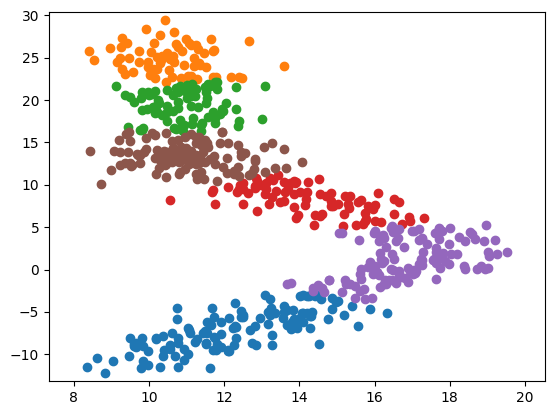

In [13]:
n_max_clusteres = 33
n_clusters_list = []
clusters_CH_index = []

# Calculamos N clústeres para comprobar cual es la agrupación óptima.
for n_clusters in range(2, n_max_clusteres):
    clusters, labels = Kmeans(n_clusters, (x, y, point_class)) # Capturamos los clústeres y las etiquetas 
    
    # Calculamos el índice de Calinski-Harabasz utilizando el método proprocionado por la biblioteca scikit.learn.
    clusters_CH_index.append(metrics.calinski_harabasz_score(list(zip(x,y)), labels))
    n_clusters_list.append(clusters)

# Escogemos la agrupación de clústeres con el mayor índice como el óptimo relativo
i = clusters_CH_index.index(max(clusters_CH_index))
clusters = n_clusters_list[i]

print(i + 2)

for cluster in clusters:
    plt.ylim(min(y) - 1, max(y) + 1)
    plt.xlim(min(x) - 1, max(x) + 1)
    plt.scatter(cluster[0], cluster[1])
plt.show()

El cálculo realizado en la celda anterior no es concurrente, por lo que no es del todo eficiente. Para arreglar ese problema, utilizamos la biblioteca estándar de python para paralelizar algoritmos utilizando hilos. El siguiente fragmento de código que se proporciona es la solución concurrente.

6


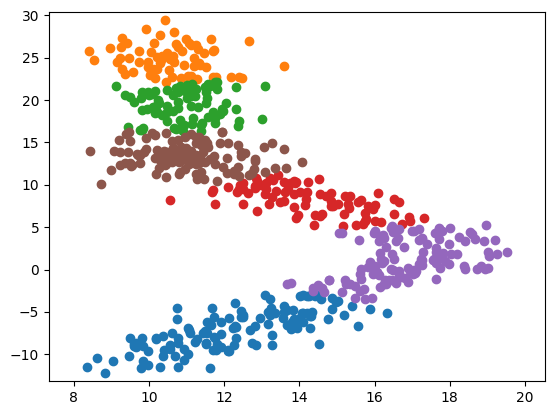

In [14]:
# Importamos la estructura de datos Queue para almacenar los clústeres de manera concurrente.
from queue import Queue 

n_max_clusteres = 33
n_clusters_list = []
clusters_CH_index = []
threads = []
clusters_queue = Queue(maxsize=n_max_clusteres) # Cola que almacena los clústeres que van a devolver los hilos
labels_queue = Queue(maxsize=n_max_clusteres) # Cola que almacena las etiquetas que van a devolver los hilos

# Calculamos N clústeres para comprobar cual es la agrupación óptima.
for n_clusters in range(2, n_max_clusteres):
    clusters, labels = Kmeans(n_clusters, (x, y, point_class)) # Capturamos los clústeres y las etiquetas 
    
    # Calculamos el índice de Calinski-Harabasz utilizando el método proprocionado por la biblioteca scikit.learn.
    clusters_CH_index.append(metrics.calinski_harabasz_score(list(zip(x,y)), labels))
    n_clusters_list.append(clusters)

# Escogemos la agrupación de clústeres con el mayor índice como el óptimo relativo
i = clusters_CH_index.index(max(clusters_CH_index))
clusters = n_clusters_list[i]

print(i + 2)

for cluster in clusters:
    plt.ylim(min(y) - 1, max(y) + 1)
    plt.xlim(min(x) - 1, max(x) + 1)
    plt.scatter(cluster[0], cluster[1])
plt.show()

Una vez desarrollado y probado que se muestran los datos correctamente, procedemos a comprobar que la salida mostrada por el algoritmo k-means de la librería sklearn es muy similar. Por lo tanto, importamos la librería.

In [15]:
from sklearn.cluster import KMeans

Una vez importado, usamos la librería para calcular el resultado. A diferencia de los notebooks anteriores, en este cálculo, se utiliza el índice Calinski-Harabasz para el cálculo del número relativo óptimo de clústeres.

11


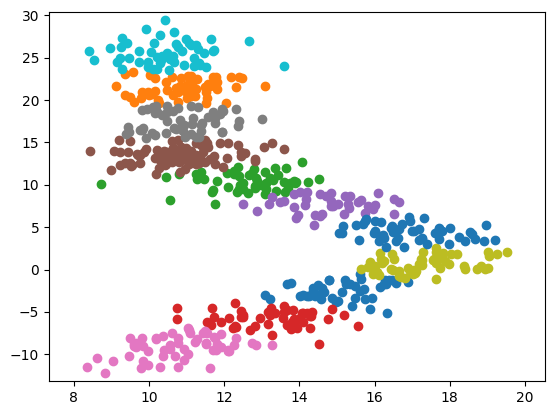

In [16]:
n_max_clusteres = 16
labels_list = []
clusters_CH_index = []

for n_clusters in range(2, n_max_clusteres):
    local_labels = KMeans(n_clusters=n_clusters).fit_predict(list(zip(x,y)))
    index = metrics.calinski_harabasz_score(list(zip(x,y)), local_labels)
    clusters_CH_index.append(index)
    labels_list.append(list(local_labels))

plt.ylim(min(y) - 1, max(y) + 1)
plt.xlim(min(x) - 1, max(x) + 1)

number_of_clusters = clusters_CH_index.index(max(clusters_CH_index))
labels = labels_list[number_of_clusters]
# Se le suma 2 al valor de los clústeres ya que estos comienzan desde el número de agrupación 2, no el 0.
number_of_clusters = number_of_clusters + 2

print(number_of_clusters)

clusters = []
for cluster_number in range(number_of_clusters):
    clusters.append([[], []])
    for i in range(len(labels)):
        if(labels[i] == cluster_number):
            clusters[cluster_number][0].append(x[i])
            clusters[cluster_number][1].append(y[i])
            


plt.ylim(min(y) - 1, max(y) + 1)
plt.xlim(min(x) - 1, max(x) + 1)

for cluster in clusters:
    plt.scatter(cluster[0], cluster[1])
plt.show()